In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
event_df_test = pd.read_csv("event_data_test.csv")
submissions_df_test = pd.read_csv("submission_data_test.csv")

In [3]:
event_df_train = pd.read_csv("event_data_train.csv")
submissions_df_train = pd.read_csv("submission_data_train.csv")

In [4]:
#Calculates whether a user has done 40 practical steps correctly
correct_steps = submissions_df_train[['user_id', 'submission_status']].query('submission_status=="correct"') \
.groupby('user_id', as_index=False).count().rename(columns={'submission_status': 'passed_course'})

In [5]:
PASSED_THRESHOLD = 40
y = correct_steps.assign(passed_course=correct_steps.passed_course >= PASSED_THRESHOLD)
#This dataframe misses some user_id, those who didn't submit anything
y.head()

,user_id,passed_course
0,2,False
1,3,False
2,5,False
3,8,False
4,16,True


In [6]:
#Aggregates different actions, correct and wrong submissions for each user within 2 days period

#First we need to filter the data by 2 days period. A starting point is the first registered event.
TWO_DAYS_SECONDS = 2*24*60*60
two_days_timestamp = event_df_train[['timestamp', 'user_id']].groupby('user_id', as_index=False).agg({'timestamp': 'min'})
two_days_timestamp = two_days_timestamp.assign(timestamp=two_days_timestamp.timestamp + TWO_DAYS_SECONDS).rename(columns={'timestamp': 'timestamp_threshold'})

two_days_timestamp.head()

,user_id,timestamp_threshold
0,1,1473000264
1,2,1514556164
2,3,1434531276
3,5,1466329609
4,7,1521807460


In [44]:
event_df_train['day'] = pd.to_datetime(event_df_train.timestamp, unit='s').dt.date

filtered_event_df_train = event_df_train.merge(two_days_timestamp, on='user_id', how='outer').query('timestamp <= timestamp_threshold')

user_scores = filtered_event_df_train.pivot_table(index='user_id', columns='action', values='step_id', \
                                                  aggfunc='count', fill_value=0) \
    .reset_index().rename_axis("", axis="columns")
user_scores['day'] = filtered_event_df_train.groupby('user_id', as_index=False).agg({'day': pd.Series.nunique}).day
user_scores.head()

,user_id,discovered,passed,started_attempt,viewed,day
0,1,1,0,0,1,1
1,2,9,9,2,9,1
2,3,15,15,4,20,1
3,5,1,1,0,1,1
4,7,1,1,0,1,1


In [45]:
#Do the same for submissions
filtered_submissions_df_train = submissions_df_train.merge(two_days_timestamp, on='user_id', how='inner') \
    .query('timestamp <= timestamp_threshold')

user_submission_status = filtered_submissions_df_train.pivot_table(index='user_id', columns='submission_status', \
                                                                   values='step_id', aggfunc='count', fill_value=0) \
    .reset_index().rename_axis("", axis="columns")

user_submission_status.head()

,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,18,23


In [100]:
user_stats = user_scores.merge(user_submission_status, on='user_id', how='left').fillna(0)
user_stats = user_stats.merge(y, on='user_id', how='left').fillna(False)
user_stats.head()
#user_stats.user_id.nunique() == event_df_train.user_id.nunique()

,user_id,discovered,passed,started_attempt,viewed,day,correct,wrong,passed_course
0,1,1,0,0,1,1,0.0,0.0,False
1,2,9,9,2,9,1,2.0,0.0,False
2,3,15,15,4,20,1,4.0,4.0,False
3,5,1,1,0,1,1,0.0,0.0,False
4,7,1,1,0,1,1,0.0,0.0,False


In [54]:
user_stats.index = user_stats.user_id
user_stats = user_stats.drop(columns='user_id')
user_stats.head()

AttributeError: 'DataFrame' object has no attribute 'user_id'

In [101]:
y = user_stats.passed_course
X = user_stats.drop(columns='passed_course')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [109]:
#Parameters were found by GridSearchCV

model = RandomForestClassifier(n_estimators=55, max_depth=6, min_samples_split=3, min_samples_leaf=2, criterion='gini')
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [108]:
#from sklearn.ensemble import GradientBoostingClassifier

#model = GradientBoostingClassifier(n_estimators=55, max_depth=6, min_samples_split=3, min_samples_leaf=2)
#grid_search_cv = RandomizedSearchCV(model, param_distributions={'max_depth': range(1, 11), 'learning_rate': [0.01, 0.1, 1.0, 5.0, 10.0], \
#                                                'n_estimators': range(10, 101, 5), 'min_samples_split': range(2, 11, 2), \
#                                                'min_samples_leaf': range(1, 11)}, \
#                              n_jobs=-1, n_iter=25000, cv=5)
#grid_search_cv.fit(X_train, y_train)
#grid_search_cv.best_params_

In [16]:
#model = grid_search_cv.best_estimator_
#model.score(X_test, y_test)

In [110]:
y_predicted_prob = model.predict_proba(X_test)
y_predicted_prob[:, 1]

array([0.2656875 , 0.14220941, 0.03114122, ..., 0.11363647, 0.02369602,
       0.02855487])

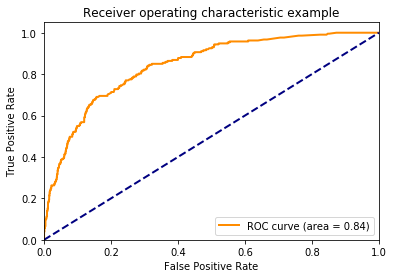

In [111]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()